# Defeating Zero Gradients: Using PGD with a Different Loss

In [1]:
%%capture
try:
    import secmlt
except ImportError:
    %pip install git+https://github.com/pralab/secml-torch

try:
    import robustbench
except ImportError:
    %pip install git+https://github.com/RobustBench/robustbench.git

In [2]:
%%capture
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchvision
from robustbench.utils import download_gdrive
from secmlt.adv.backends import Backends
from secmlt.adv.evasion.perturbation_models import LpPerturbationModels
from secmlt.adv.evasion.pgd import PGD, PGDNative
from secmlt.metrics.classification import Accuracy
from secmlt.models.pytorch.base_pytorch_nn import BasePytorchClassifier
from secmlt.optimization.losses import LogitDifferenceLoss
from secmlt.trackers import (
    GradientNormTracker,
    LossTracker,
)
from torch import nn
from torch.utils.data import DataLoader, Subset

from utils.models import MNISTModel

## Defensive distillation

The defensive distillation method (Papernot, 2016) first trains an initial network $f$ on data $x$ with a softmax temperature of $T$. Then it uses the probability vector $f(x)$, which includes additional knowledge about classes compared to a class label, predicted by network $f$, to train a distilled network $f_d$ at temperature $T$ on the same data $x$.

In other words, the network $f_d$ is trained using *soft labels*. In fact, they might not even be correct, but they are representation of what the model $f$ has learnt.

![](./assets/distillation.png)

The idea behind this defense is that the student network should learn a "hardened" function that is constant around the tested samples.


In [3]:
MODEL_ID = "1s7Kfa2Bs5nY2zLd6dVAxUqNbCNQhPYxs"

model = MNISTModel()
model_folder = Path("models")
path = model_folder / "mnist_distilled.pt"
if not path.exists():
    model_folder.mkdir(exist_ok=True)
    download_gdrive(MODEL_ID, path)
state_dict = torch.load(
    path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)
model.load_state_dict(state_dict)
model.eval()


test_dataset = torchvision.datasets.MNIST(
    transform=torchvision.transforms.ToTensor(),
    train=False,
    root="data",
    download=True,
)
test_dataset = Subset(test_dataset, list(range(3)))
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)


device = "cpu"

# Wrap model
secmlt_model = BasePytorchClassifier(model)

# Test accuracy on original data
accuracy = Accuracy()(secmlt_model, test_loader)
print(f"test accuracy: {accuracy.item():.2f}")



Download started: path=models/mnist_distilled.pt (gdrive_id=1s7Kfa2Bs5nY2zLd6dVAxUqNbCNQhPYxs)
Download finished: path=models/mnist_distilled.pt (gdrive_id=1s7Kfa2Bs5nY2zLd6dVAxUqNbCNQhPYxs)
test accuracy: 1.00


In [4]:
# Create and run attack
epsilon = 0.3
num_steps = 200
step_size = 0.005
perturbation_model = LpPerturbationModels.LINF
y_target = None

trackers = [
    LossTracker(),
    GradientNormTracker(),
]

pgd = PGD(
    perturbation_model=perturbation_model,
    epsilon=epsilon,
    num_steps=num_steps,
    step_size=step_size,
    random_start=False,
    y_target=y_target,
    backend=Backends.NATIVE,
    trackers=trackers,
)
pgd_adv_ds = pgd(secmlt_model, test_loader)

robust_accuracy = accuracy = Accuracy()(secmlt_model, pgd_adv_ds)
print(f"robust accuracy: {robust_accuracy.item():.2f}")


robust accuracy: 1.00


The robust accuracy after the attack is almost the same as the original accuracy.
Let's check again the loss function to understand the problem.

As the gradient update is defined as:

$x_{i+1} = x_i + \alpha \nabla f(x_i, y, \theta)$,

there might be two possibilities. Either the step size is too small, or the gradient is zero!

If the gradient is zero, the point $x_i$ is never updated!
Let's check the size of the gradient (any norm is fine).

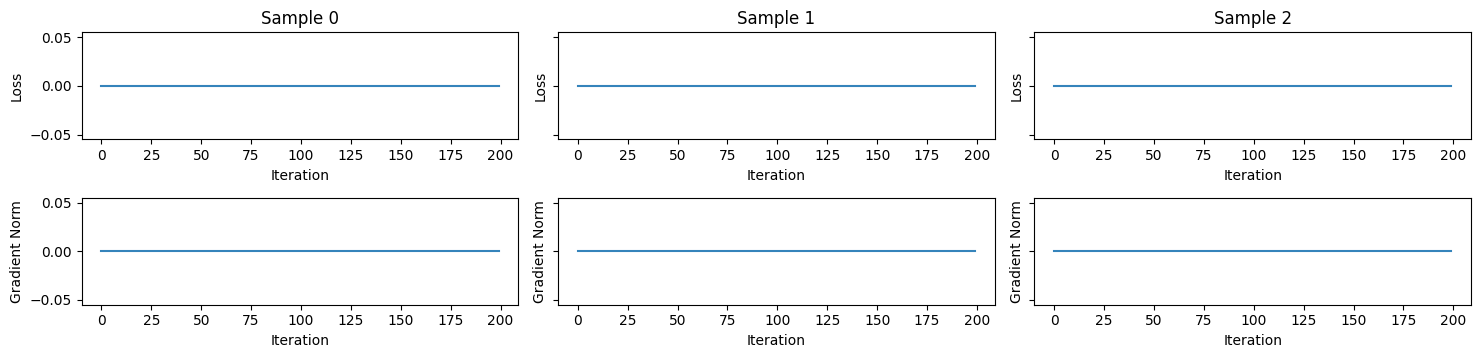

In [5]:
loss_pgd = pgd.trackers[0].get()
grad_nodrm_pgd = pgd.trackers[1].get()

num_samples = loss_pgd.shape[0]

fig, axes = plt.subplots(
    nrows=2, ncols=num_samples, figsize=(5 * num_samples, 4), sharey=True
)

for i in range(num_samples):
    axes[0, i].plot(loss_pgd[i], linestyle="-", alpha=0.9, label="PGD")
    axes[0, i].set_xlabel("Iteration")
    axes[0, i].set_ylabel("Loss")
    axes[0, i].set_title(f"Sample {i}")
    axes[1, i].plot(grad_nodrm_pgd[i], linestyle="-", alpha=0.9, label="PGD")
    axes[1, i].set_xlabel("Iteration")
    axes[1, i].set_ylabel("Gradient Norm")


# add one shared legend
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


The distillation defense leverages a specific trick that makes the softmax function saturate, hence making its computations on the gradient *unstable*.

The softmax function is usually cascaded after DNNs to get outputs that look like probabilities, *i.e.*, to sum up to 1.

This defense can be broken by removing the softmax

In [6]:

class PGDWithDifferenceOfLogits(PGDNative):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_function = LogitDifferenceLoss()


trackers = [
    LossTracker(),
    GradientNormTracker(),
]

adaptive_attack = PGDWithDifferenceOfLogits(
    perturbation_model=perturbation_model,
    epsilon=epsilon,
    num_steps=num_steps,
    step_size=step_size,
    random_start=False,
    y_target=y_target,
    backend=Backends.NATIVE,
    trackers=trackers,
)

adaptive_attack_ds = adaptive_attack(secmlt_model, test_loader)

robust_accuracy = accuracy = Accuracy()(secmlt_model, adaptive_attack_ds)
print(f"robust accuracy: {robust_accuracy.item():.2f}")

robust accuracy: 0.00


Now we can display the gradient norm and the loss of the PGD attack with the difference of logits loss.


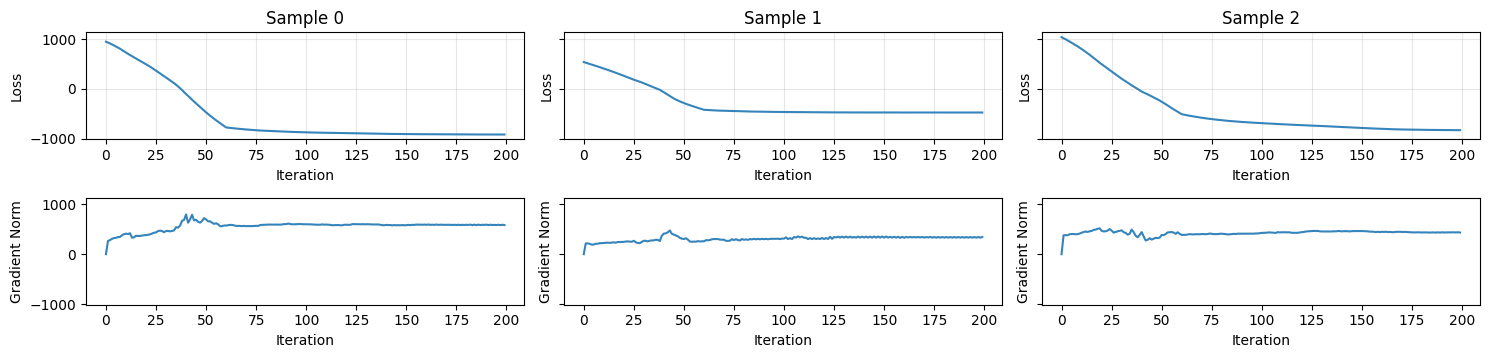

In [7]:
loss_adaptive_pgd = adaptive_attack.trackers[0].get()
grad_nodrm_adaptive_pgd = adaptive_attack.trackers[1].get()

num_samples = loss_adaptive_pgd.shape[0]

fig, axes = plt.subplots(
    nrows=2, ncols=num_samples, figsize=(5 * num_samples, 4), sharey=True
)

for i in range(num_samples):
    axes[0, i].plot(loss_adaptive_pgd[i], linestyle="-", alpha=0.9, label="Adaptive PGD")
    axes[0, i].set_xlabel("Iteration")
    axes[0, i].set_ylabel("Loss")
    axes[0, i].set_title(f"Sample {i}")
    axes[0, i].grid(alpha=0.3)
    axes[1, i].plot(grad_nodrm_adaptive_pgd[i], linestyle="-", alpha=0.9, label="Adaptive PGD")
    axes[1, i].set_xlabel("Iteration")
    axes[1, i].set_ylabel("Gradient Norm")


# add one shared legend
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


Note that there is another straightforward way of finding adversarial examples for the student model.
Hint: remember that the distilled network is learning an approximation of the teacher network!

In [8]:
MODEL_ID = '1qmjepc4k_o4BIqCvUJgwg-K19CaovOrQ'

teacher_model = MNISTModel()
teacher_path = model_folder/"mnist_teacher.pt"
if teacher_path.exists() is False:
    download_gdrive(MODEL_ID, teacher_path)
teacher_state_dict = torch.load(teacher_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
teacher_model.load_state_dict(teacher_state_dict)
teacher_model.eval()

# Wrap model
secmlt_teacher_model = BasePytorchClassifier(teacher_model)

# run PGD attack on teacher model
teacher_adv_ds = pgd(secmlt_teacher_model, test_loader)

# test robust accuracy of teacher model on adversarial examples found on itself
robust_accuracy = accuracy = Accuracy()(secmlt_teacher_model, teacher_adv_ds)
print(f"teacher robust accuracy: {robust_accuracy.item():.2f}")

# test robust accuracy of student model on adversarial examples found on teacher model
robust_accuracy = accuracy = Accuracy()(secmlt_model, teacher_adv_ds)
print(f"student robust accuracy on teacher adv examples: {robust_accuracy.item():.2f}")

Download started: path=models/mnist_teacher.pt (gdrive_id=1qmjepc4k_o4BIqCvUJgwg-K19CaovOrQ)
Download finished: path=models/mnist_teacher.pt (gdrive_id=1qmjepc4k_o4BIqCvUJgwg-K19CaovOrQ)
teacher robust accuracy: 0.00
student robust accuracy on teacher adv examples: 0.00


## References
* Nicolas Papernot, Patrick McDaniel, Xi Wu, Somesh Jha, and Ananthram Swami. Distillation as a defense to adversarial perturbations against deep neural networks. In 2016 IEEE symposium on security and privacy (SP), 582–597. IEEE, 2016.
* Carlini, Nicholas and David A. Wagner. Defensive Distillation is Not Robust to Adversarial Examples. ArXiv abs/1607.04311 (2016): n. pag.